In [62]:
from utils import load_and_prepare_building_dfs, get_voll_temps, normalize_building_dfs, get_building_type
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from kneed import KneeLocator
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
building_dfs = load_and_prepare_building_dfs(esave_path="data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls", vis_path='data/VIS Målere.xlsx')
temp = get_voll_temps(voll_path='data/Volltemp.xlsx')

Data loaded in 87.36158037185669 seconds


In [3]:
plt.rcParams['figure.figsize'] = (20, 5)

for building_name, building_df in list(building_dfs.items()):
    building_dfs[building_name] = building_df.resample('D').sum()
    if building_df.isnull().values.any():
        building_dfs.pop(building_name)

    elif building_df.isna().values.any():
        building_dfs.pop(building_name)

print(len(building_dfs))

daily_temp = temp.resample('D').mean()['Eklima_68860_TAM']

building_dfs = normalize_building_dfs(building_dfs, method='min-max')

172


In [4]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, dx, dy):
        self.dx = dx
        self.dy = dy

    def expected(self, temperature):
        if temperature < self.dx[0]:
            # print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            # TODO improve this prediction
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            # print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series, threshold):
        expected_series = self.get_expected_series(temperature_series)
        mask = (energy_series - expected_series).abs() >= threshold
        return energy_series[mask]

    def get_mse(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return ((energy_series - expected_series) ** 2).mean()

    def get_top_diffs(self, energy_series, temperature_series, n):
        expected_series = self.get_expected_series(temperature_series)
        diffs = (energy_series - expected_series).abs()
        # sort diffs in descending order
        sorted_diffs = diffs.sort_values(ascending=False)
        # get the top n values
        top_n = sorted_diffs[:n]
        return top_n

    def plot(self, energy_series, temperature_series, threshold=None):
        plt.plot(self.dx, self.dy, color='red', linewidth=4)

        # if threshold is given, find anomalies and color them in the scatter plot
        plt.scatter(temperature_series, energy_series, color='blue')
        if threshold is not None:
            anomalies = self.get_anomolies_series(energy_series, temperature_series, threshold)
            plt.scatter(temperature_series[anomalies.index], energy_series[anomalies.index], color='red', s=100)
            # plot one curve over and under the expected curve
            sorted_temperature_series = temperature_series.sort_values()
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) + threshold, color='green', linewidth=3)
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) - threshold, color='green', linewidth=3)
            
        plt.show()

In [5]:
def model_1(energy_consumption_series: pd.Series, temperature_series: pd.Series, points_per_segment, plot: bool = False):
    # ensure that we match values for energy and temp
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points + 1, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = LinearRegression()
        model.fit(X_seg, y_seg)

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])

    return et_curve(dx, dy)

Using data from building: Trondheim Kommune - Buran helse og Velferdssenter


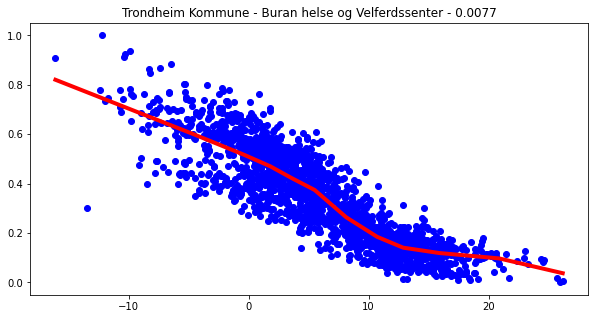

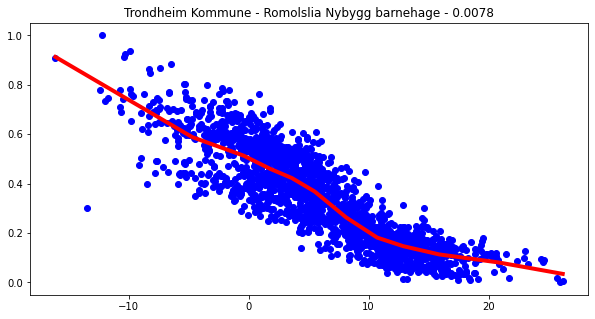

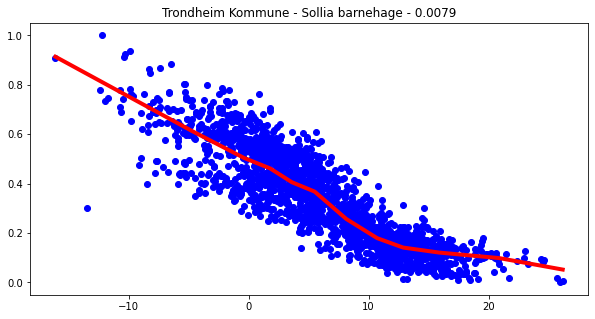

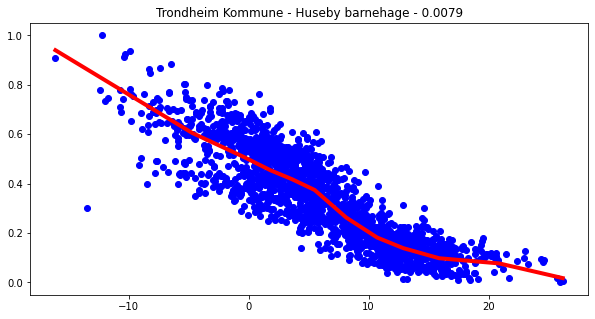

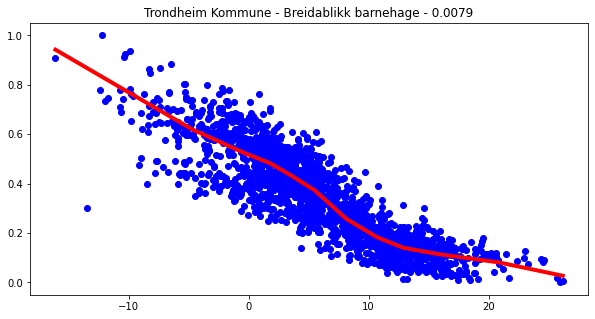

In [6]:
# create ET curves for all buildings
building_et_results = []
for building_name, building_df in list(building_dfs.items()):
    building_energy = building_df['Totalt']
    et_model = model_1(building_energy, daily_temp, 200)
    et_mse = et_model.get_mse(building_energy, daily_temp)
    building_et_results.append((building_name, et_mse, et_model))

# get a random building name
test_name = list(building_dfs.keys())[50]
test_df = building_dfs[test_name]
test_energy = test_df['Totalt']
print("Using data from building:", test_name)

test_building_et_results = []
# test random building data on all models
for building_tuple in building_et_results:
    building_name, building_mse, building_model = building_tuple
    mse = building_model.get_mse(test_energy, daily_temp)
    test_building_et_results.append((building_name, mse, building_model))

# sort results by mse
test_building_et_results.sort(key=lambda x: x[1])

# plot the 5 best results
for i in range(5):
    building_name, mse, building_model = test_building_et_results[i]
    plt.title(f'{building_name} - {mse:.4f}')
    building_model.plot(test_energy, daily_temp)


In [13]:
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_results = []

for building_name, building_df in list(building_dfs.items()):
    building_energy = building_df['Totalt']
    avg_mse = 0
    for day_index, day in enumerate(week_days):
        # get day data
        days = building_energy.loc[building_energy.index.weekday == day_index]
        day_temp = daily_temp.loc[daily_temp.index.weekday == day_index]
        day_model = model_1(days, day_temp, 50)
        day_mse = day_model.get_mse(days, day_temp)
        avg_mse += day_mse
    avg_mse /= 7
    daily_results.append((building_name, avg_mse))

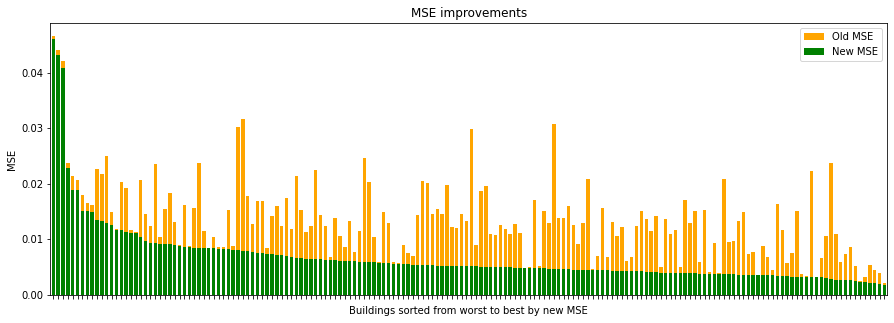

Trondheim Kommune - Presthus gård barnehage: ratio(8.0685) daily_mse(0.0029) old_mse(0.0237)
Trondheim Kommune - Munkvoll barnehage: ratio(7.0198) daily_mse(0.0032) old_mse(0.0223)
Trondheim Kommune - Korsvika barnehage: ratio(6.6149) daily_mse(0.0047) old_mse(0.0308)


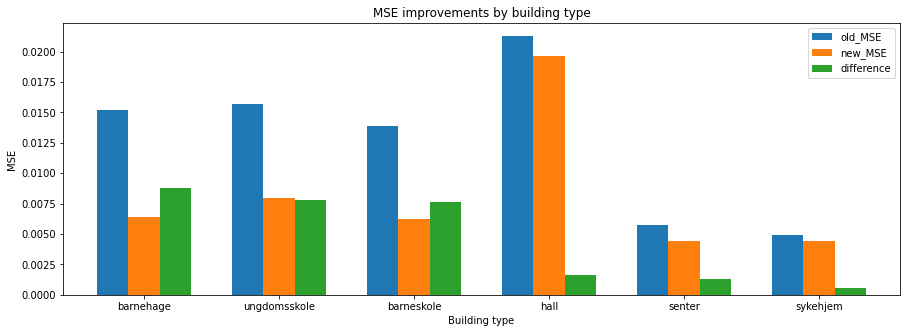

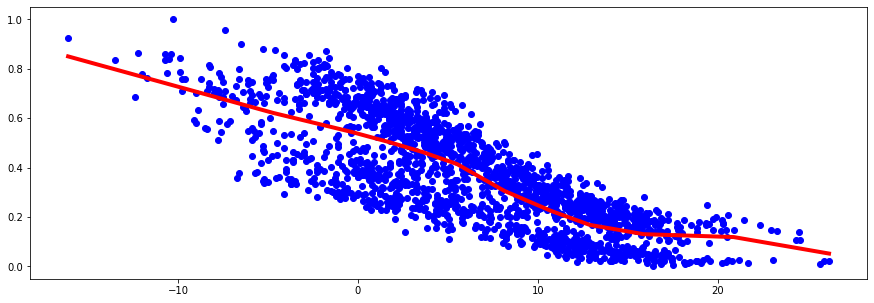

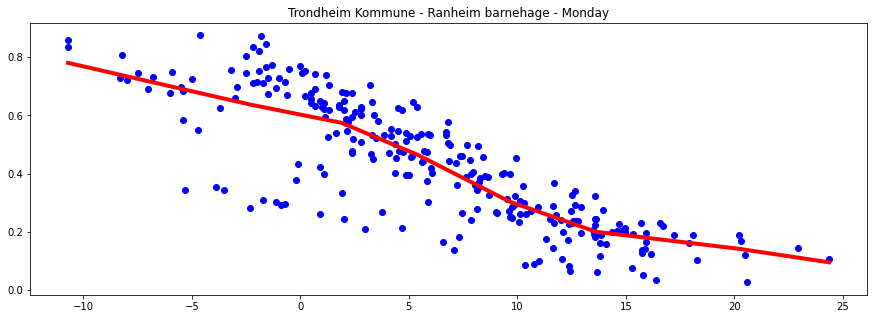

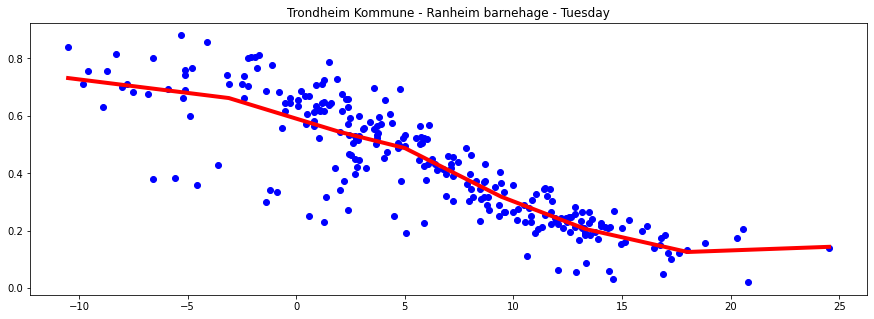

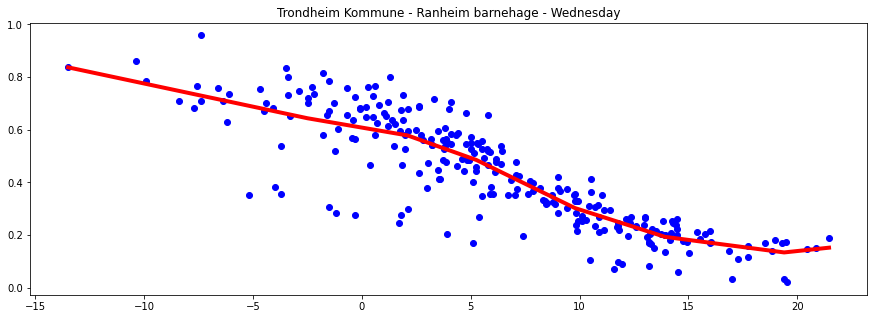

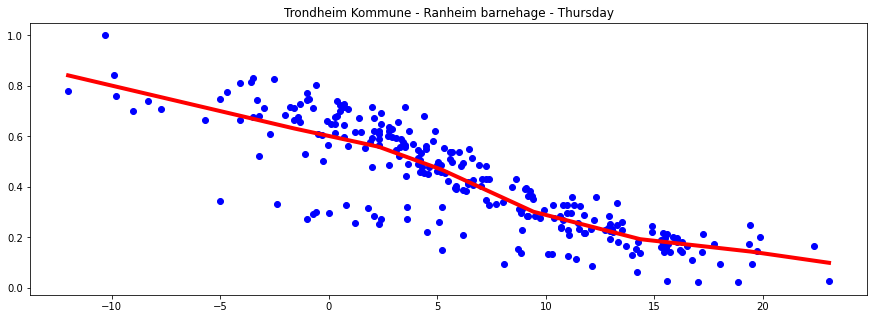

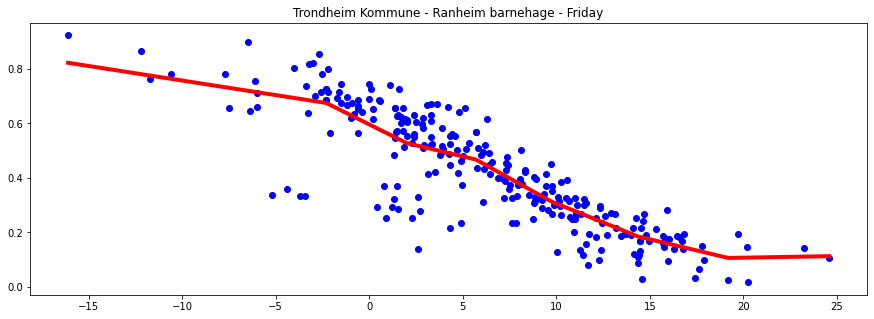

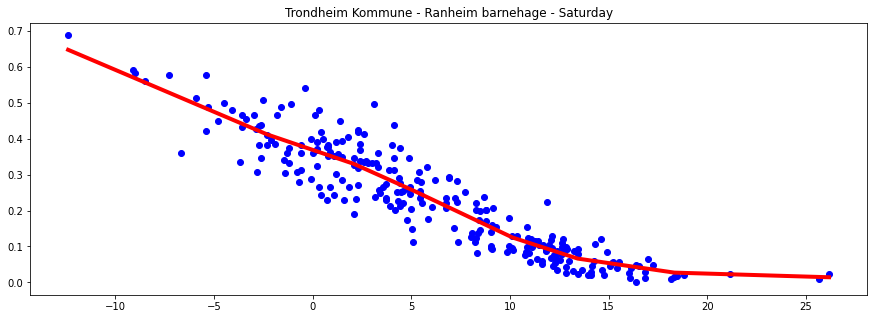

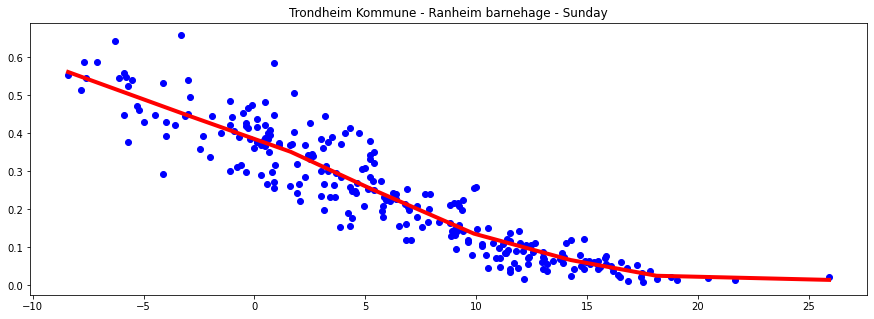

In [63]:
# compare mses of all buildings with daily and not daily results
daily_results.sort(key=lambda x: x[0])
building_et_results.sort(key=lambda x: x[0])

mse_diffs = []
for i in range(len(daily_results)):
    building_name, mse, building_model = building_et_results[i]
    daily_name, daily_mse = daily_results[i]
    mse_diffs.append((building_name, mse/daily_mse, daily_mse, mse))

# create pandas dataframe with old and new mses
mse_diffs_df = pd.DataFrame(mse_diffs, columns=['building', 'sum', 'daily_mse', 'old_mse'])
mse_diffs_df.sort_values(by='daily_mse', inplace=True, ascending=False)
# plot the mses

_, ax = plt.subplots()
mse_diffs_df.old_mse.plot.bar(ax=ax, color='orange', label='Old MSE', width=0.7)
mse_diffs_df.daily_mse.plot.bar(ax=ax, color='green', label='New MSE', width=0.7)
ax.legend()
ax.title.set_text('MSE improvements')
# remove x axis values
ax.set_xticklabels([])
ax.set_xlabel('Buildings sorted from worst to best by new MSE')
ax.set_ylabel('MSE')
plt.show()

# sort mse_diffs by ratio
mse_diffs.sort(key=lambda x: x[1], reverse=True)

# print 3 biggest ratio
for i in range(3):
    building_name, diff, daily_mse, mse = mse_diffs[i]
    print(f'{building_name}: ratio({diff:.4f}) daily_mse({daily_mse:.4f}) old_mse({mse:.4f})')

# find average improvement in each building type
types = ['barneskole', 'ungdomsskole', 'hall', 'senter', 'barnehage', 'sykehjem']
building_type_stats = {}
for type in types:
    building_type_stats[type] = {'old_MSE': 0, 'new_MSE': 0, 'difference': 0, 'ratio': 0, 'counter': 0}

for building_name, ratio, daily_mse, mse in mse_diffs:
    building_type = get_building_type(building_name)
    if building_type is None:
        continue

    building_type_stats[building_type]['old_MSE'] += mse
    building_type_stats[building_type]['new_MSE'] += daily_mse
    building_type_stats[building_type]['difference'] += mse - daily_mse
    building_type_stats[building_type]['ratio'] += ratio
    building_type_stats[building_type]['counter'] += 1

# create table of building type stats, then plot barchart
building_type_stats_table = pd.DataFrame.from_dict(building_type_stats, orient='index')
# divide by counter to get average
building_type_stats_table['old_MSE'] /= building_type_stats_table['counter']
building_type_stats_table['new_MSE'] /= building_type_stats_table['counter']
building_type_stats_table['difference'] /= building_type_stats_table['counter']
building_type_stats_table['ratio'] /= building_type_stats_table['counter']
# remove counter and ratio colum
building_type_stats_table.drop(columns=['counter'], inplace=True)
building_type_stats_table.drop(columns=['ratio'], inplace=True)
# sort by difference
building_type_stats_table.sort_values(by='difference', inplace=True, ascending=False)
building_type_stats_table.plot.bar(width=0.7)
plt.legend()
plt.title('MSE improvements by building type')
# make x label horizontal
plt.xticks(rotation=0)
plt.xlabel('Building type')
plt.ylabel('MSE')
plt.show()

# plot building with biggest ratio
building_name, diff, daily_mse, mse = mse_diffs[100]
building_df = building_dfs[building_name]
building_energy = building_df['Totalt']
building_model = model_1(building_energy, daily_temp, 200)
building_model.plot(building_energy, daily_temp)

# plot the same building with daily data
for day in week_days:
    days = building_energy.loc[building_energy.index.weekday == week_days.index(day)]
    day_temp = daily_temp.loc[daily_temp.index.weekday == week_days.index(day)]
    day_model = model_1(days, day_temp, 50)
    plt.title(f'{building_name} - {day}')
    day_model.plot(days, day_temp)

size: 261 pps: 262, slices: 1


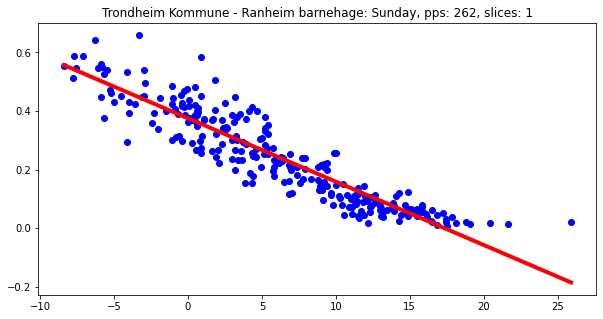

size: 261 pps: 131, slices: 2


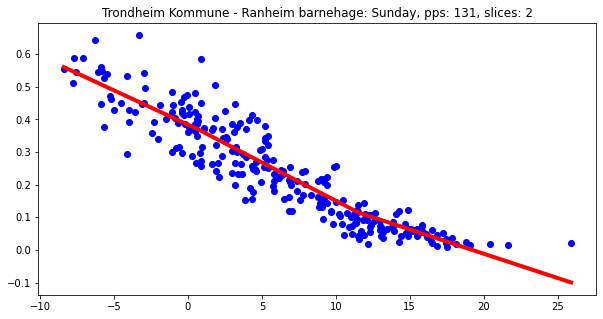

size: 261 pps: 88, slices: 3


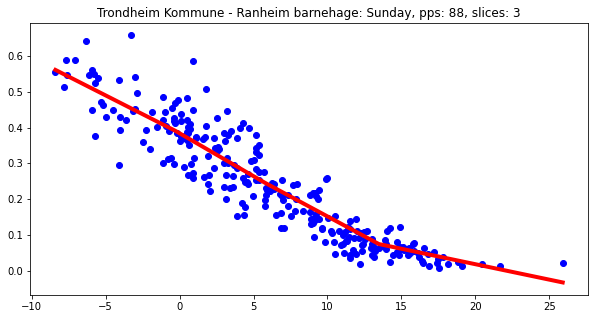

size: 261 pps: 66, slices: 4


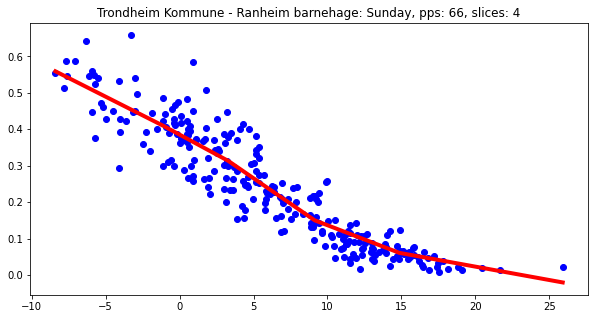

size: 261 pps: 53, slices: 5


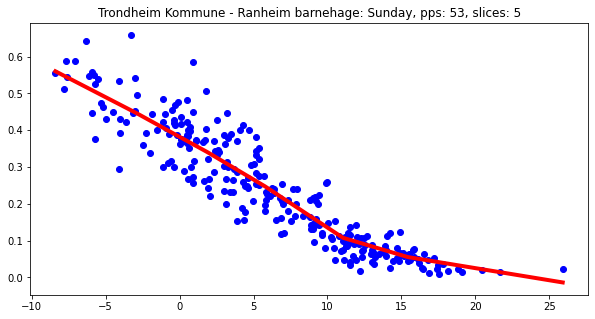

size: 261 pps: 44, slices: 6


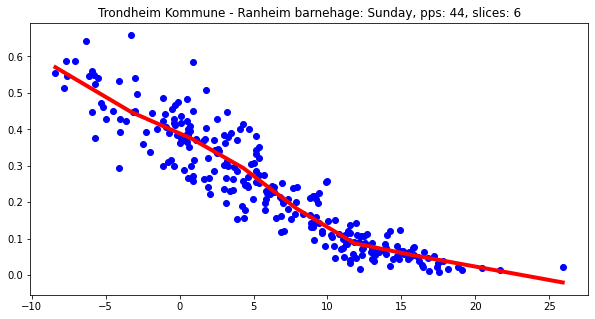

size: 261 pps: 38, slices: 7


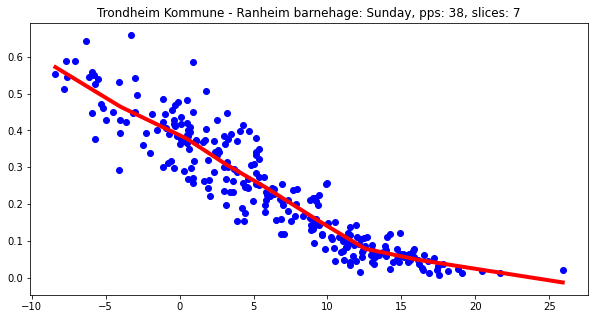

size: 261 pps: 33, slices: 8


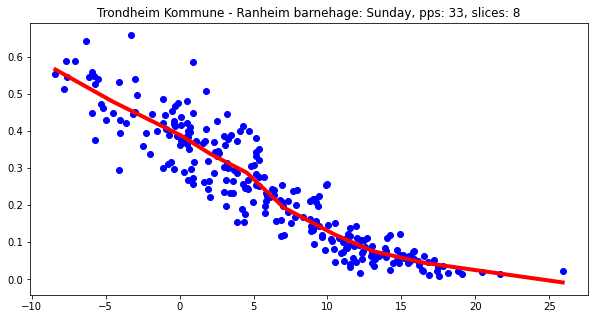

size: 261 pps: 30, slices: 9


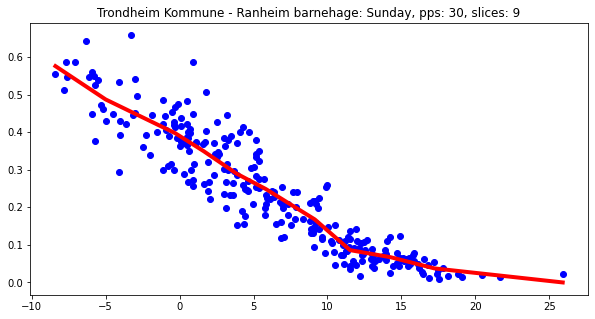

size: 261 pps: 27, slices: 10


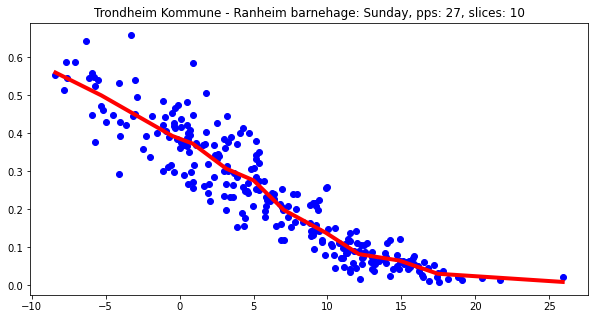

size: 261 pps: 24, slices: 11


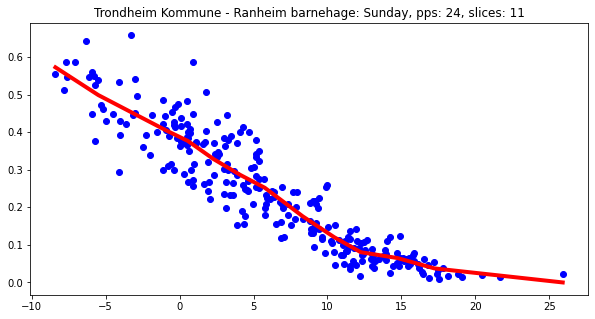

size: 261 pps: 22, slices: 12


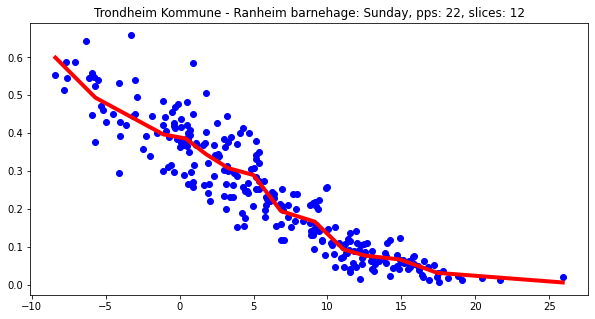

size: 261 pps: 21, slices: 13


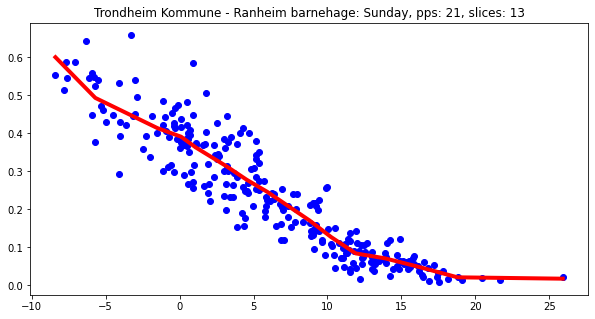

size: 261 pps: 19, slices: 14


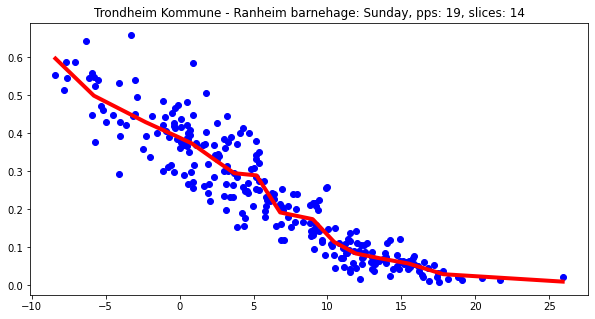

size: 261 pps: 18, slices: 15


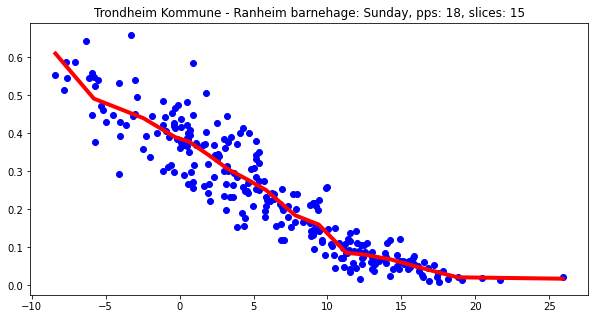

size: 261 pps: 17, slices: 16


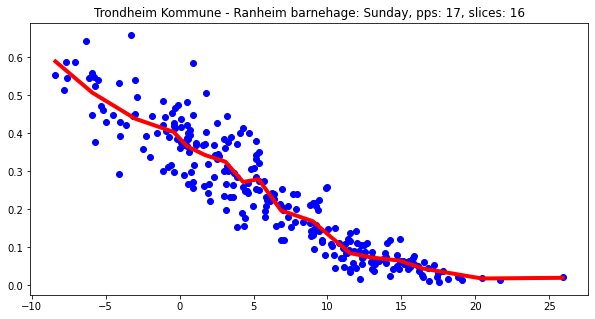

size: 261 pps: 16, slices: 17


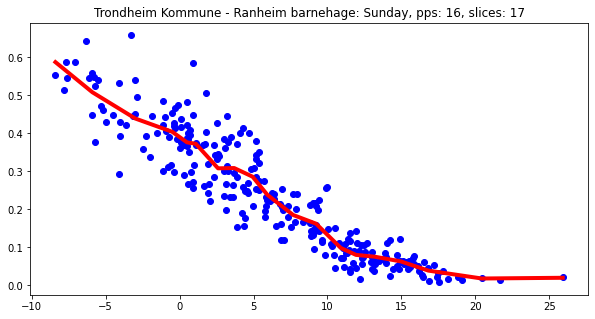

size: 261 pps: 15, slices: 18


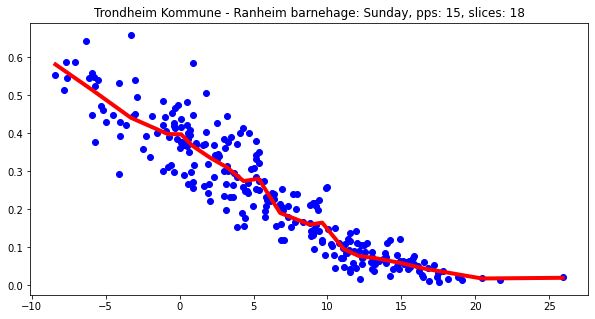

size: 261 pps: 14, slices: 19


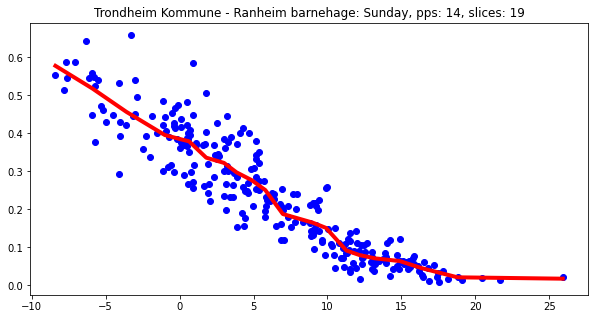

19 19


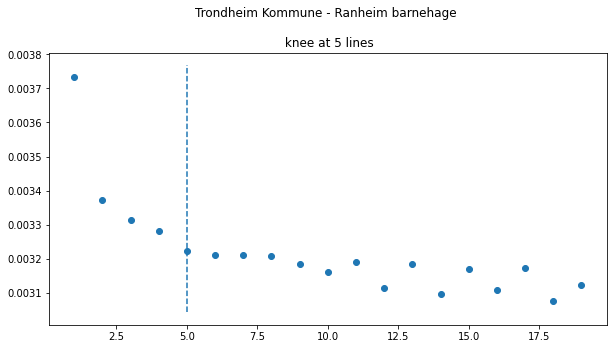

In [9]:
# test out how many lines
ppss = range(1,20)
pps_results = []

# 10 first buildings
for slices in ppss:
    avg_mse = 0
    for day_index, day in enumerate(week_days):
        # get day data
        days = building_energy.loc[building_energy.index.weekday == day_index]
        day_temp = daily_temp.loc[daily_temp.index.weekday == day_index]
        data_size = len(days)
        pps = data_size // slices + 1
        
        day_model = model_1(days, day_temp, pps)
        day_mse = day_model.get_mse(days, day_temp)
        
        if day == 'Sunday':
            avg_mse += day_mse
            print(f'size: {data_size} pps: {pps}, slices: {slices}')
            plt.title(f'{building_name}: {day}, pps: {pps}, slices: {slices}')
            day_model.plot(days, day_temp)

    pps_results.append(avg_mse)

print(len(pps_results), len(ppss))

plt.scatter(ppss, pps_results)
# find knee point
kneedle = KneeLocator(ppss, pps_results, curve='convex', direction='decreasing')
knee_idx = kneedle.knee
plt.vlines(knee_idx, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.title(f'{building_name} \n\n knee at {knee_idx} lines')
plt.show()


In [10]:
# create ETT for all buildings

ETT_curves = {}
for building_name, building_df in list(building_dfs.items()):
    building_energy = building_df['Totalt']
    avg_mse = 0
    for day_index, day in enumerate(week_days):
        # get day data
        days = building_energy.loc[building_energy.index.weekday == day_index]
        day_temp = daily_temp.loc[daily_temp.index.weekday == day_index]
        day_model = model_1(days, day_temp, 50)
        day_mse = day_model.get_mse(days, day_temp)
        avg_mse += day_mse
    avg_mse /= 7
    daily_results.append((building_name, avg_mse))